In [270]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [271]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [272]:
waterDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4


In [273]:
waterDF['일자'].dtype

dtype('<M8[ns]')

In [274]:
waterDF['년'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month
waterDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,년,월
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4,2021,1
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4,2021,1
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3,2021,1
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2,2021,1
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4,2021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,2025,9
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6,2025,9
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5,2025,10
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4,2025,10


In [277]:
waterDF.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
수온,404.0,18.056188,8.431139,2.800,10.67500,19.0000,25.22500,32.000
수소이온농도(ph),404.0,7.912376,0.536458,6.500,7.60000,7.9000,8.30000,9.200
전기전도도(EC),404.0,297.460396,107.355447,118.000,206.50000,279.5000,388.00000,516.000
용존산소(DO),404.0,10.372030,2.407574,6.600,8.40000,9.6000,11.92500,16.000
BOD,404.0,1.876485,0.723801,0.400,1.30000,1.7500,2.30000,4.400
COD,404.0,5.998515,1.082983,4.200,5.20000,5.9000,6.60000,11.600
부유물질,404.0,7.247277,7.381532,0.400,3.60000,6.0000,8.80000,100.800
총질소(T-N),404.0,2.449906,0.618431,0.804,2.04225,2.4205,2.91025,3.800
총인(T-P),404.0,0.042918,0.026786,0.015,0.02700,0.0335,0.04900,0.281
총유기탄소(TOC),404.0,3.973762,0.805721,2.100,3.40000,3.9000,4.50000,7.000


In [278]:
wc = waterDF.select_dtypes(include='number').corr()
wc

,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,년,월
수온,1.000000,0.120104,-0.672522,-0.888829,-0.025502,0.590225,0.285153,-0.652434,0.280791,0.407686,0.344139,0.066079,0.093061,0.448209
수소이온농도(ph),0.120104,1.000000,0.060053,0.124342,0.355301,0.248950,-0.098774,-0.349092,-0.477242,0.193473,-0.362927,0.522877,-0.036895,0.100557
전기전도도(EC),-0.672522,0.060053,1.000000,0.598234,0.233873,-0.334750,-0.326295,0.448558,-0.409117,-0.255261,-0.425005,-0.063253,-0.285601,-0.533178
용존산소(DO),-0.888829,0.124342,0.598234,1.000000,0.245966,-0.382175,-0.266339,0.546105,-0.365427,-0.234853,-0.410225,0.218189,-0.058692,-0.499017
BOD,-0.025502,0.355301,0.233873,0.245966,1.000000,0.472863,0.136457,0.066447,-0.051870,0.411794,-0.082820,0.520125,-0.021355,-0.412502
COD,0.590225,0.248950,-0.334750,-0.382175,0.472863,1.000000,0.459506,-0.367602,0.255526,0.788921,0.284284,0.494771,-0.047390,0.196426
부유물질,0.285153,-0.098774,-0.326295,-0.266339,0.136457,0.459506,1.000000,-0.170686,0.367831,0.343668,0.767870,0.240041,-0.085349,0.105157
총질소(T-N),-0.652434,-0.349092,0.448558,0.546105,0.066447,-0.367602,-0.170686,1.000000,0.086836,-0.100489,-0.149945,-0.156235,-0.031479,-0.485403
총인(T-P),0.280791,-0.477242,-0.409117,-0.365427,-0.051870,0.255526,0.367831,0.086836,1.000000,0.241748,0.479433,-0.126405,0.183828,0.100337
총유기탄소(TOC),0.407686,0.193473,-0.255261,-0.234853,0.411794,0.788921,0.343668,-0.100489,0.241748,1.000000,0.161918,0.467857,-0.109864,0.132803


In [279]:
waterDF['지점'] = np.where(waterDF['총량지점명'].str.contains('물금', na=False), '물금',
                np.where(waterDF['총량지점명'].str.contains('금곡', na=False), '금곡', np.nan))

Text(0, 0.5, '클로로필-a')

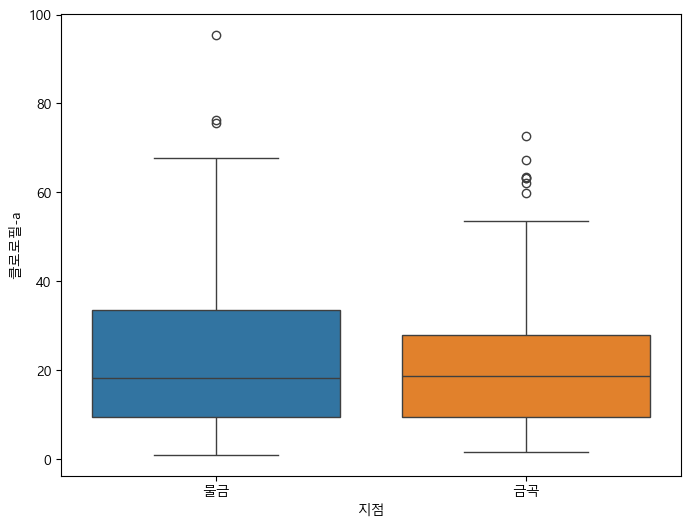

In [280]:
plt.figure(figsize=(8,6))
sb.boxplot(x='총량지점명', y='클로로필-a', hue='총량지점명', data=waterDF)
plt.xlabel('지점')
plt.ylabel('클로로필-a')

In [281]:
waterDF.dtypes.sort_values()

부유물질                 float64
일자            datetime64[ns]
월                      int32
년                      int32
수온                   float64
수소이온농도(ph)           float64
전기전도도(EC)            float64
용존산소(DO)             float64
BOD                  float64
COD                  float64
총질소(T-N)             float64
총인(T-P)              float64
총유기탄소(TOC)           float64
유량                   float64
클로로필-a               float64
총량지점명                 object
지점                    object
dtype: object

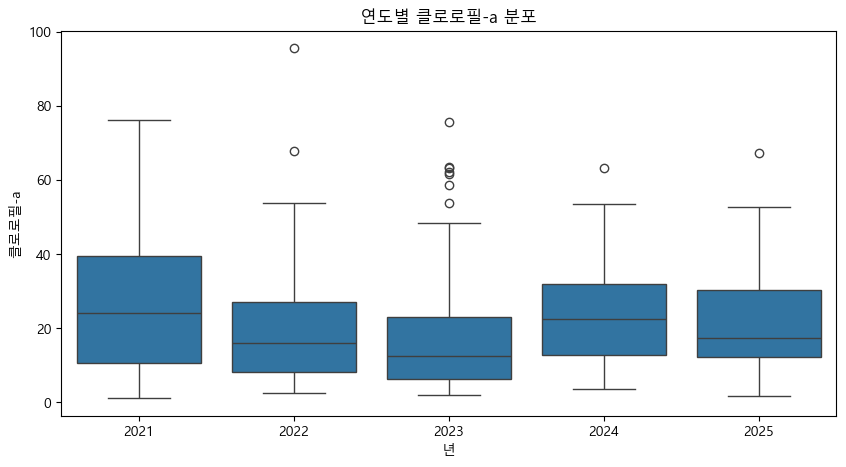

In [282]:
plt.figure(figsize=(10,5))
sb.boxplot(data=waterDF, x='년', y='클로로필-a')
plt.title('연도별 클로로필-a 분포')
plt.show()

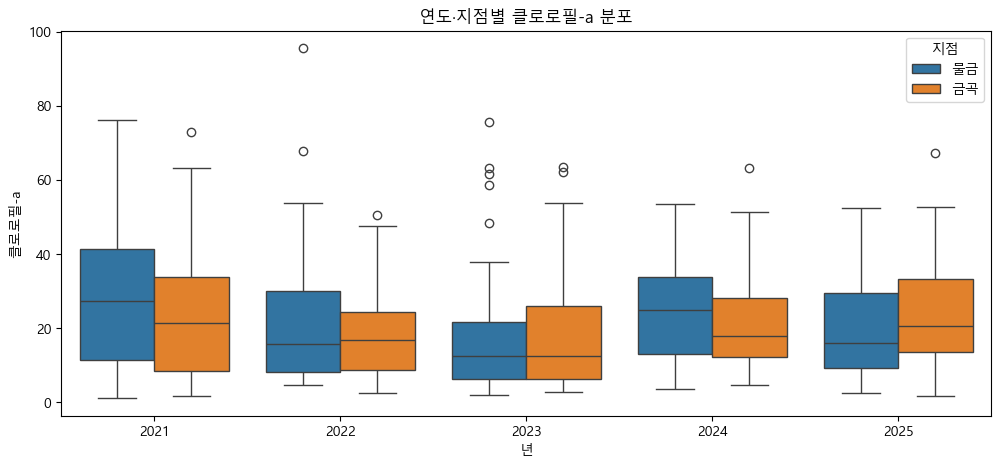

In [283]:
plt.figure(figsize=(12,5))
sb.boxplot(data=waterDF, x='년', y='클로로필-a', hue='지점')
plt.title('연도·지점별 클로로필-a 분포')
plt.show()


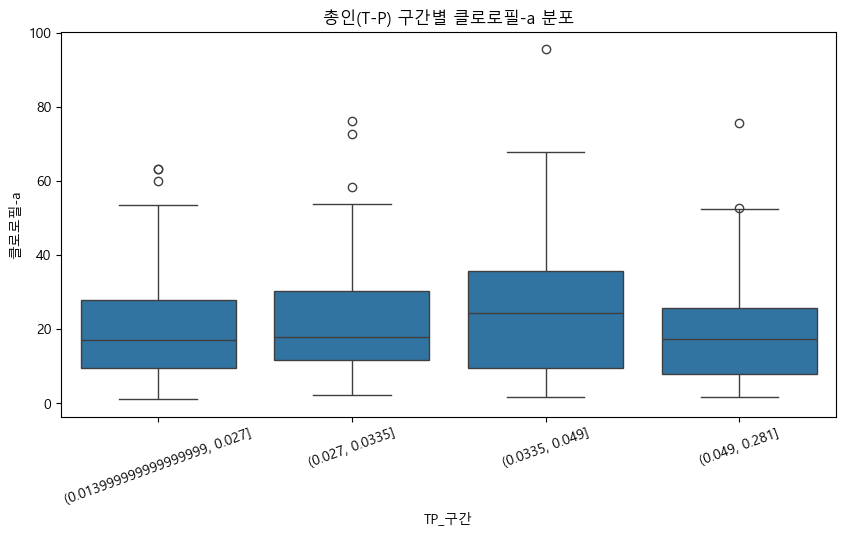

In [284]:
# 총인 구간화
waterDF['TP_구간'] = pd.qcut(waterDF['총인(T-P)'], 4)

plt.figure(figsize=(10,5))
sb.boxplot(data=waterDF, x='TP_구간', y='클로로필-a')
plt.title('총인(T-P) 구간별 클로로필-a 분포')
plt.xticks(rotation=20)
plt.show()


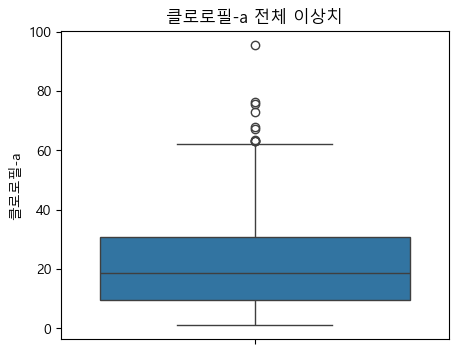

In [285]:
plt.figure(figsize=(5,4))
sb.boxplot(y=waterDF['클로로필-a'])
plt.title('클로로필-a 전체 이상치')
plt.show()


In [286]:
# 위험도 분리
waterDF['녹조위험'] = pd.cut(
    waterDF['클로로필-a'],
    bins=[-np.inf, 10, 25, np.inf],
    labels=[0, 1, 2]  # 낮음, 보통, 높음
)

In [287]:
modelDF = waterDF.dropna(subset=['녹조위험']).copy()

In [288]:
feature_cols = [
    '총인(T-P)','총질소(T-N)','BOD','COD',
    '수온','유량','용존산소(DO)','전기전도도(EC)'
]

modelDF['지점'] = np.where(
    modelDF['총량지점명'].str.contains('물금'), '물금', '금곡'
)

df_mulgum = modelDF[modelDF['지점']=='물금']
df_geumgok = modelDF[modelDF['지점']=='금곡']


In [289]:
X_m = df_mulgum[feature_cols]
y_m = df_mulgum['녹조위험'].astype(int)

In [290]:
modelDF = waterDF.dropna(subset=['녹조위험']).copy()
modelDF.head()

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,년,월,지점,TP_구간,녹조위험
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4,2021,1,물금,"(0.013999999999999999, 0.027]",1
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4,2021,1,물금,"(0.027, 0.0335]",1
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3,2021,1,물금,"(0.013999999999999999, 0.027]",2
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2,2021,1,물금,"(0.027, 0.0335]",2
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4,2021,2,물금,"(0.013999999999999999, 0.027]",2


In [291]:
X_m = df_mulgum[feature_cols]
y_m = df_mulgum['녹조위험'].astype(int)

In [292]:
imp_m = SimpleImputer(strategy='median')
X_m_imp = imp_m.fit_transform(X_m)

In [293]:
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(
    X_m_imp, y_m,
    test_size=0.2,
    random_state=42,
    stratify=y_m
)

## LogisticRegression

In [294]:
logi_m = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial'
)

logi_m.fit(X_m_train, y_m_train)


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [295]:
y_m_pred = logi_m.predict(X_m_test)
y_m_pred

array([2, 1, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 0, 0, 0,
       2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1,
       1])

In [296]:
print('[물금]')
print(confusion_matrix(y_m_test, y_m_pred))
print(classification_report(y_m_test, y_m_pred))

[물금]
[[8 4 0]
 [2 9 5]
 [0 9 8]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.41      0.56      0.47        16
           2       0.62      0.47      0.53        17

    accuracy                           0.56        45
   macro avg       0.61      0.57      0.58        45
weighted avg       0.59      0.56      0.56        45



In [297]:
coef_m = pd.Series(
    logi_m.coef_[list(logi_m.classes_).index(2)],
    index=feature_cols
).sort_values(ascending=False)

coef_m


BOD          1.644905
COD          0.854064
용존산소(DO)     0.132352
유량          -0.001662
전기전도도(EC)   -0.012338
수온          -0.132964
총인(T-P)     -0.159936
총질소(T-N)    -0.901176
dtype: float64

“물금 지점은 총인·총질소보다는 BOD와 COD 등 유기물 지표에 의해 녹조 위험이 크게 증가하는 특성을 보였다.”

“고위험 녹조 사례의 상당수가 중위험으로 분류되어, 물금 지점은 녹조 위험 경계가 점진적으로 상승하는 구조를 가진 것으로 해석된다.”

“이는 물금 지점이 유기물 축적형 녹조 발생 메커니즘을 가질 가능성을 시사한다.”

지금 상태에서의 결론

물금 단독 모델 성능은 통합 모델보다 낮음

이유:

표본 수 감소

고위험 경계가 불명확

하지만 해석력은 매우 높음 → 분석적으로는 성공

In [298]:
df_geumgok.shape, df_geumgok['녹조위험'].value_counts()

((179, 19),
 녹조위험
 1    74
 2    58
 0    47
 Name: count, dtype: int64)

In [299]:
X_g = df_geumgok[feature_cols]
y_g = df_geumgok['녹조위험'].astype(int)

In [300]:
# 결측치 처리
imp_g = SimpleImputer(strategy='median')
X_g_imp = imp_g.fit_transform(X_g)


In [301]:
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(
    X_g_imp, y_g,
    test_size=0.2,
    random_state=42,
    stratify=y_g
)


In [302]:
logi_g = LogisticRegression(max_iter=1000, multi_class='multinomial')
logi_g.fit(X_g_train, y_g_train)


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


In [303]:
y_g_pred = logi_g.predict(X_g_test)

print('[금곡]')
print(confusion_matrix(y_g_test, y_g_pred))
print(classification_report(y_g_test, y_g_pred))


[금곡]
[[ 7  2  0]
 [ 3 10  2]
 [ 1  4  7]]
              precision    recall  f1-score   support

           0       0.64      0.78      0.70         9
           1       0.62      0.67      0.65        15
           2       0.78      0.58      0.67        12

    accuracy                           0.67        36
   macro avg       0.68      0.68      0.67        36
weighted avg       0.68      0.67      0.67        36



In [304]:
coef_g = pd.Series(
    logi_g.coef_[list(logi_g.classes_).index(2)],
    index=feature_cols
).sort_values(ascending=False)

coef_g


BOD          1.642641
COD          0.999677
용존산소(DO)     0.078843
유량          -0.001422
전기전도도(EC)   -0.011619
총인(T-P)     -0.062676
수온          -0.164830
총질소(T-N)    -1.008903
dtype: float64

In [305]:
coef_compare = pd.concat([coef_m.rename('물금'), coef_g.rename('금곡')], axis=1)
coef_compare['물금-금곡'] = coef_compare['물금'] - coef_compare['금곡']
coef_compare.sort_values('물금-금곡', ascending=False)

,물금,금곡,물금-금곡
총질소(T-N),-0.901176,-1.008903,0.107727
용존산소(DO),0.132352,0.078843,0.053510
수온,-0.132964,-0.164830,0.031866
BOD,1.644905,1.642641,0.002264
유량,-0.001662,-0.001422,-0.000239
전기전도도(EC),-0.012338,-0.011619,-0.000720
총인(T-P),-0.159936,-0.062676,-0.097260
COD,0.854064,0.999677,-0.145613


In [306]:
# 물금: 고위험 확률
proba_m = logi_m.predict_proba(X_m_test)
proba_m_high = proba_m[:, list(logi_m.classes_).index(2)]

# 금곡: 고위험 확률
proba_g = logi_g.predict_proba(X_g_test)
proba_g_high = proba_g[:, list(logi_g.classes_).index(2)]


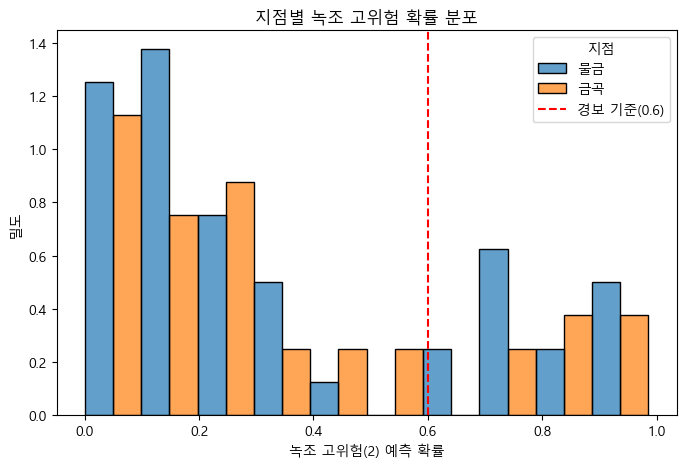

In [307]:
plt.figure(figsize=(8,5))

ax = sb.histplot(
    data=plotDF,
    x='고위험확률',
    hue='지점',
    hue_order=['물금','금곡'],
    bins=10,
    stat='density',
    multiple='dodge',
    alpha=0.7,
    legend=True
)

# 1) seaborn이 만든 범례(물금/금곡)를 먼저 확보
leg = ax.get_legend()
leg.set_title('지점')

# 2) 기준선 그리기(라인 객체)
vline = ax.axvline(0.6, color='red', linestyle='--', label='경보 기준(0.6)')

# 3) 기존 범례의 핸들/라벨을 가져와 기준선만 추가
handles = leg.legend_handles
labels = [t.get_text() for t in leg.get_texts()]

handles = list(handles) + [vline]
labels  = list(labels)  + ['경보 기준(0.6)']

# 4) 범례를 “한 번만” 다시 세팅
ax.legend(handles=handles, labels=labels, title='지점', loc='upper right')

plt.xlabel('녹조 고위험(2) 예측 확률')
plt.ylabel('밀도')
plt.title('지점별 녹조 고위험 확률 분포')
plt.show()


In [308]:
print('물금 평균 고위험확률:', proba_m_high.mean())
print('금곡 평균 고위험확률:', proba_g_high.mean())


물금 평균 고위험확률: 0.3475548597840724
금곡 평균 고위험확률: 0.33913827185215073


In [309]:
alert_m = (proba_m_high >= 0.6).mean()
alert_g = (proba_g_high >= 0.6).mean()

alert_m, alert_g


(0.28888888888888886, 0.2222222222222222)

해석 핵심(요점)

물금 평균 고위험확률이 금곡보다 소폭 높음

물금: 0.3476

금곡: 0.3391

두 지점 모두 저확률(0~0.3) 구간 비중이 큼

평상시에는 고위험으로 판단되는 날이 많지 않다는 의미

0.6 기준선 오른쪽(경보 구간) 존재

해당 구간에 막대가 나타나는 지점은 고위험으로 강하게 분류되는 관측치가 있는 것

경보 발령 기준을 0.6으로 잡으면 이 구간의 표본이 실제 대응 대상이 됨

In [310]:
def eval_threshold(y_true, proba_high, threshold):
    # 경보 여부 (확률 기준)
    alarm = (proba_high >= threshold).astype(int)

    # 실제 고위험 여부
    y_true_high = (y_true == 2).astype(int)

    alarm_rate = alarm.mean()
    recall = recall_score(y_true_high, alarm, zero_division=0)
    precision = precision_score(y_true_high, alarm, zero_division=0)

    return alarm_rate, recall, precision


In [311]:
thresholds = [0.5, 0.6, 0.7]
rows = []

for t in thresholds:
    ar, rc, pr = eval_threshold(y_m_test, proba_m_high, t)
    rows.append(['물금', t, ar, rc, pr])

    ar, rc, pr = eval_threshold(y_g_test, proba_g_high, t)
    rows.append(['금곡', t, ar, rc, pr])

resultDF = pd.DataFrame(
    rows,
    columns=['지점', '경보기준', '경보발령률', '고위험_재현율', '정밀도']
)

resultDF


,지점,경보기준,경보발령률,고위험_재현율,정밀도
0,물금,0.5,0.288889,0.470588,0.615385
1,금곡,0.5,0.250000,0.583333,0.777778
2,물금,0.6,0.288889,0.470588,0.615385
3,금곡,0.6,0.222222,0.583333,0.875000
4,물금,0.7,0.244444,0.411765,0.636364
5,금곡,0.7,0.222222,0.583333,0.875000


In [312]:
thresholds = np.arange(0.3, 0.81, 0.05)

In [313]:
rows = []

for t in thresholds:
    ar, rc, pr = eval_threshold(y_m_test, proba_m_high, t)
    rows.append(['물금', t, ar, rc, pr])

    ar, rc, pr = eval_threshold(y_g_test, proba_g_high, t)
    rows.append(['금곡', t, ar, rc, pr])

thresholdDF = pd.DataFrame(
    rows,
    columns=['지점', '경보기준', '경보발령률', '고위험_재현율', '정밀도']
)

thresholdDF


,지점,경보기준,경보발령률,고위험_재현율,정밀도
0,물금,0.30,0.400000,0.764706,0.722222
1,금곡,0.30,0.388889,0.750000,0.642857
2,물금,0.35,0.333333,0.588235,0.666667
3,금곡,0.35,0.333333,0.750000,0.750000
4,물금,0.40,0.311111,0.529412,0.642857
5,금곡,0.40,0.305556,0.666667,0.727273
6,물금,0.45,0.288889,0.470588,0.615385
7,금곡,0.45,0.277778,0.666667,0.800000
8,물금,0.50,0.288889,0.470588,0.615385
9,금곡,0.50,0.250000,0.583333,0.777778


In [314]:
validDF = thresholdDF[thresholdDF['고위험_재현율'] >= 0.7]
validDF

,지점,경보기준,경보발령률,고위험_재현율,정밀도
0,물금,0.30,0.400000,0.764706,0.722222
1,금곡,0.30,0.388889,0.750000,0.642857
3,금곡,0.35,0.333333,0.750000,0.750000


In [315]:
optimalDF = (
    validDF
    .sort_values(['지점','경보발령률'])
    .groupby('지점')
    .first()
    .reset_index()
)

optimalDF

,지점,경보기준,경보발령률,고위험_재현율,정밀도
0,금곡,0.35,0.333333,0.750000,0.750000
1,물금,0.30,0.400000,0.764706,0.722222


In [316]:
# 물금 기준
th_m = optimalDF.loc[optimalDF['지점']=='물금','경보기준'].values[0]
alarm_m = (proba_m_high >= th_m).mean()

# 금곡 기준
th_g = optimalDF.loc[optimalDF['지점']=='금곡','경보기준'].values[0]
alarm_g = (proba_g_high >= th_g).mean()

alarmDF = pd.DataFrame({
    '지점': ['물금','금곡'],
    '경보발령률': [alarm_m, alarm_g]
})

alarmDF


,지점,경보발령률
0,물금,0.400000
1,금곡,0.333333


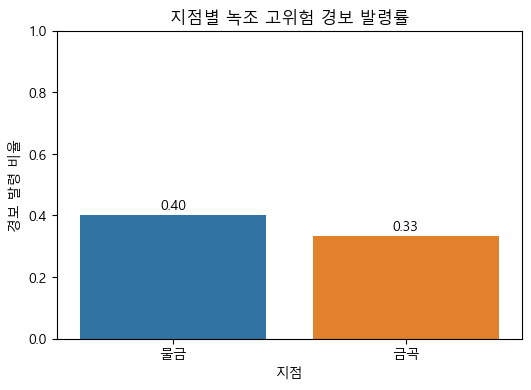

In [317]:
plt.figure(figsize=(6,4))
sb.barplot(
    data=alarmDF,
    x='지점',
    y='경보발령률',
    hue='지점',
    palette={'물금':'tab:blue','금곡':'tab:orange'},
    dodge=False
)

plt.ylabel('경보 발령 비율')
plt.title('지점별 녹조 고위험 경보 발령률')
plt.ylim(0,1)

for i, v in enumerate(alarmDF['경보발령률']):
    plt.text(i, v+0.02, f'{v:.2f}', ha='center')

plt.show()

In [318]:
# 지점별 최적 경보 기준
th_m = optimalDF.loc[optimalDF['지점']=='물금','경보기준'].values[0]
th_g = optimalDF.loc[optimalDF['지점']=='금곡','경보기준'].values[0]

# 확률 예측 (전체 데이터 기준)
proba_all_m = logi_m.predict_proba(
    SimpleImputer(strategy='median').fit_transform(df_mulgum[feature_cols])
)[:, list(logi_m.classes_).index(2)]

proba_all_g = logi_g.predict_proba(
    SimpleImputer(strategy='median').fit_transform(df_geumgok[feature_cols])
)[:, list(logi_g.classes_).index(2)]

# 경보 여부 컬럼 추가
df_mulgum = df_mulgum.copy()
df_geumgok = df_geumgok.copy()

df_mulgum['경보'] = (proba_all_m >= th_m).astype(int)
df_geumgok['경보'] = (proba_all_g >= th_g).astype(int)


In [319]:
# 월 컬럼 확인 (없으면 생성)
df_mulgum['월'] = df_mulgum['일자'].dt.month
df_geumgok['월'] = df_geumgok['일자'].dt.month

monthly_m = df_mulgum.groupby('월')['경보'].mean().reset_index()
monthly_m['지점'] = '물금'

monthly_g = df_geumgok.groupby('월')['경보'].mean().reset_index()
monthly_g['지점'] = '금곡'

monthlyDF = pd.concat([monthly_m, monthly_g], ignore_index=True)
monthlyDF


,월,경보,지점
0,1,0.526316,물금
1,2,0.500000,물금
2,3,0.625000,물금
3,4,0.350000,물금
4,5,0.250000,물금
5,6,0.400000,물금
6,7,0.500000,물금
7,8,0.550000,물금
8,9,0.619048,물금
9,10,0.684211,물금


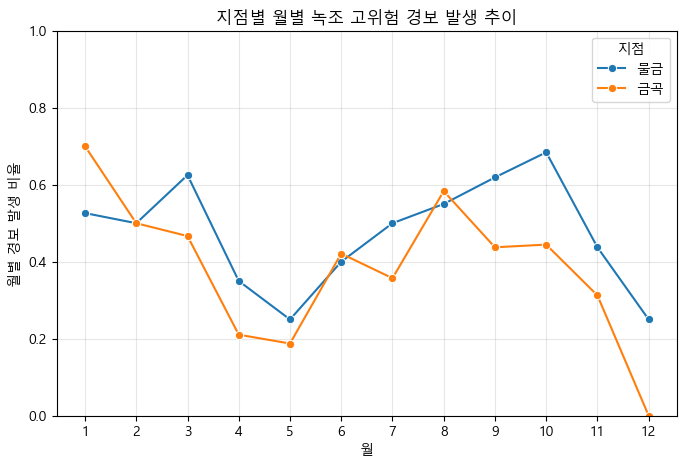

In [320]:
plt.figure(figsize=(8,5))

sb.lineplot(
    data=monthlyDF,
    x='월',
    y='경보',
    hue='지점',
    palette={'물금':'tab:blue','금곡':'tab:orange'},
    marker='o'
)

plt.ylabel('월별 경보 발생 비율')
plt.xlabel('월')
plt.title('지점별 월별 녹조 고위험 경보 발생 추이')
plt.ylim(0,1)
plt.xticks(range(1,13))
plt.legend(title='지점')
plt.grid(alpha=0.3)
plt.show()


### 해석 포인트 

경보 발생이 특정 월(주로 여름철)에 집중되는지

물금 vs 금곡:

어느 지점이 더 이른 시점부터 경보가 증가하는지

어느 지점이 피크가 더 높은지

최적 기준 적용 후에도 계절성이 유지되는지

### 결론 문장

“월별 경보 발생 추이를 분석한 결과, 녹조 고위험 경보는 특정 계절에 집중되는 경향을 보였으며, 물금 지점은 금곡 지점보다 경보 발생 시점이 상대적으로 이른 특징을 나타냈다.”

“이는 지점별 수질 반응 특성 차이에 따른 차등적 시기 관리의 필요성을 시사한다.”